## **NLP - Text Classification Project**
Group H - August 2025

Classification of tweets from Twitter that have been manually tagged for sentiment analysis.

In [49]:
from wordcloud import WordCloud, STOPWORDS
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import time
import glob
import nltk
import evaluate
import transformers

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hilla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hilla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hilla\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [50]:
# Load data
df_train = pd.read_csv('data/Corona_NLP_train.csv', encoding='latin1')
df_val = pd.read_csv('data/Corona_NLP_test.csv', encoding='latin1')

### *Data Visualization*
Visualize raw data to understand data distributions, explore frequent words, find outliers or imbalances in the data.

**Sentiment Label Distribution**

Visualizaion of sentiment labels distribution in both the training and validation sets. This helped to quickly identify potential class imbalances. Then calculation of the percentage of each sentiment to quantitatively assess how balanced the data is.

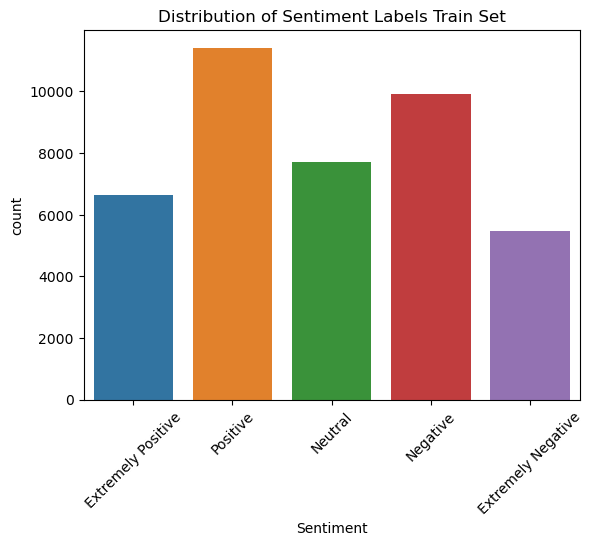

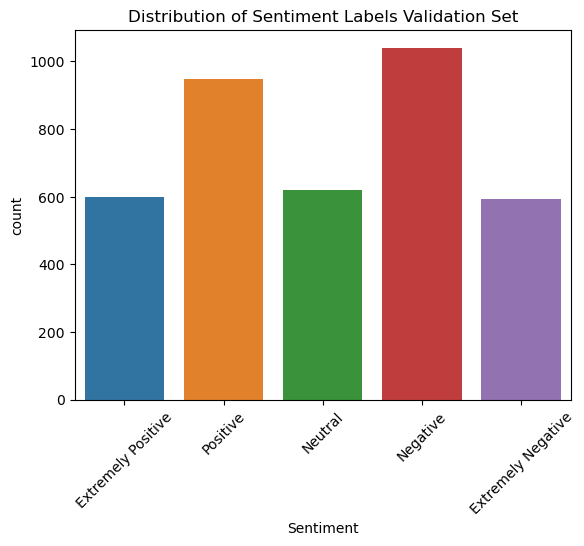

In [51]:
## Visualize distribution of sentiment labels
# Find all unique labels and reorder them for the bar plot
sentiment_labels = df_train['Sentiment'].unique()
labels_new_order = ['Extremely Positive','Positive','Neutral','Negative','Extremely Negative']

# Plot distribution
sns.countplot(data=df_train, x='Sentiment', order=labels_new_order)
plt.title("Distribution of Sentiment Labels Train Set")
plt.xticks(rotation=45)
plt.show()

sns.countplot(data=df_val, x='Sentiment', order=labels_new_order)
plt.title("Distribution of Sentiment Labels Validation Set")
plt.xticks(rotation=45)
plt.show()

In [52]:
# Show labels percentages - examine if data is imbalanced
label_counts_train = df_train['Sentiment'].value_counts()
label_percentages_train = df_train['Sentiment'].value_counts(normalize=True) * 100

label_counts_val = df_val['Sentiment'].value_counts()
label_percentages_val = df_val['Sentiment'].value_counts(normalize=True) * 100

# Display percentages
print("Label Distribution Train(%):")
print(label_percentages_train.round(2))

print("\nLabel Distribution Validation(%):")
print(label_percentages_val.round(2))

Label Distribution Train(%):
Positive              27.75
Negative              24.10
Neutral               18.74
Extremely Positive    16.09
Extremely Negative    13.32
Name: Sentiment, dtype: float64

Label Distribution Validation(%):
Negative              27.41
Positive              24.93
Neutral               16.30
Extremely Positive    15.77
Extremely Negative    15.59
Name: Sentiment, dtype: float64


**Finding Junk Locations**

After reviewing the location data, it became evident that many entries were either ambiguous, non-geographic, or entirely fictional. To prevent these from skewing the analysis, such locations were identified and tagged as "unknown". 

Known junk patterns (e.g., "earth", "everywhere" etc.) were filtered using keyword matching.

In [53]:
# Junk keywords to catch broad cases
junk_keywords = [
        'earth', 'everywhere', 'nowhere', 'somewhere', 'your heart', 'in your', 'here','kitchen',
        'dreams', 'global', 'anywhere', 'the world', 'internet', 'mars', 'moon', 'sun', 'planet',
        'universe', 'home', 'outer space', 'narnia', 'hogwarts', 'mordor', 'where', 'location',
        'matrix', 'heaven', 'hell', 'bed', 'tatooine', 'gotham', 'vagabond', 'there',
        'middle of nowhere', 'lost', 'cyberspace', 'nan'
]

In [54]:
# Count how many rows match the keyword-based junk filter
def find_junk(df, set_name):
    junk_by_keyword = df['Location'].astype(str).str.lower().apply(
        lambda loc: any(keyword in loc for keyword in junk_keywords)
    ).sum()

    # Display junk count
    print(f"Junk matched by keywords for {set_name} set: {junk_by_keyword}")

    # Calculate percentage
    junk_percentage = round((junk_by_keyword / len(df_train)) * 100, 2)
    print(f"Percentage of junk locations for {set_name} set: {junk_percentage}%")

In [55]:
find_junk(df_train, 'train')
find_junk(df_val, 'validation')

Junk matched by keywords for train set: 9878
Percentage of junk locations for train set: 24.0%
Junk matched by keywords for validation set: 951
Percentage of junk locations for validation set: 2.31%


#### Filtering Junk Locations

To improve location accuracy, we defined a function that filters out junk entries. It marks any location as `'unknown'` if it contains:

- Keywords from the predefined junk list
- Digits (e.g., coordinates, postal codes)
- Unwanted punctuation (excluding commas)

The cleaned and filtered results are stored in a new column, allowing further processing to focus only on meaningful locations.

In [56]:
def mark_junk_locations(df, junk_list, location_col='Location', new_col='Location_cleaned'):
    def is_junk(loc):
        loc = str(loc).strip().lower()

        # Check for junk keywords
        if any(keyword in loc for keyword in junk_list):
            return True

        # Check for digits
        if any(char.isdigit() for char in loc):
            return True

        # Check for punctuation (excluding comma)
        allowed_punctuation = {','}
        if any(char in string.punctuation and char not in allowed_punctuation for char in loc):
            return True

        return False

    # Clean and mark
    df[new_col] = df[location_col].astype(str).str.strip().str.lower()
    df[new_col] = df[new_col].apply(lambda loc: 'unknown' if is_junk(loc) else loc)

    return df

In [57]:
# Apply junk cleaner
df_train = mark_junk_locations(df_train, junk_keywords)
df_val = mark_junk_locations(df_val, junk_keywords)

#### Geocoding Tweet Locations - PRE-PROCESSING

Tweet locations often appear in different forms (e.g., "london", "london, uk"). To unify them, we used a geocoder (Nominatim), which grouped similar locations by mapping them to the same country. The process was done in chunks to handle rate limits and saved to CSVs for reuse — there's no need to rerun it, as it is time-consuming.

In [58]:
# def run_geocoder(df, set_name):
#     # Setup geocoder
#     geolocator = Nominatim(user_agent="tweet-country-mapper")

#     def get_country(location):
#         # Handle NaNs
#         if pd.isna(location):  
#             return None
#         loc = str(location).strip().lower()
#         if loc in {"nan", "none", "", "unknown", "null"}:
#             return None

#         try:
#             geo = geolocator.geocode(location, language='en', timeout=10)
#             if geo and geo.raw.get("display_name"):
#                 parts = geo.raw["display_name"].split(",")
#                 return parts[-1].strip()
#         except GeocoderTimedOut:
#             return get_country(location) 
#         except Exception:
#             return None

#     # Chunk helper
#     def chunk_list(lst, chunk_size):
#         for i in range(0, len(lst), chunk_size):
#             yield lst[i:i + chunk_size]

#     # Run geocoding in chunks
#     def geocode_in_chunks(locations, chunk_size=500, delay=1.1, start_chunk=0):
#         chunks = list(chunk_list(locations, chunk_size))
#         for idx, chunk in enumerate(chunks[start_chunk:], start=start_chunk):
#             print(f"Processing chunk {idx + 1} of {len(chunks)}...")

#             result = {}
#             for loc in tqdm(chunk):
#                 time.sleep(delay)
#                 result[loc] = get_country(loc)

#             # Save to CSV
#             df_part = pd.DataFrame(list(result.items()), columns=['Location', 'Country'])
#             df_part.to_csv(f'tmp/{set_name}/geocoded_part_{idx + 1}.csv', index=False)

#             print(f"Saved geocoded_part_{idx + 1}.csv")

#     # Replace this with unique cleaned locations
#     unique_locations = df['Location_cleaned'].dropna().unique().tolist()

#     geocode_in_chunks(unique_locations, chunk_size=500, delay=1.1)

In [59]:
# ## Merging all Chunks CSVs into one CSV
# def merge_geo_csvs(set_name):
#     # Load all parts from tmp
#     all_parts = glob.glob(f"tmp/{set_name}/geocoded_part_*.csv")

#     merged = pd.concat([pd.read_csv(part) for part in all_parts], ignore_index=True)

#     # Save final merged file
#     merged.to_csv(f"geocoded_full_{set_name}_set.csv", index=False)
#     print("Saved final geocoded_full.csv")

In [60]:
# # Run geocoder preprocessing for train and validation sets
# run_geocoder(df_train, 'train')
# merge_geo_csvs('train')

# run_geocoder(df_val, 'validation')
# merge_geo_csvs('validation')

**Map locations to countries after pre-processing** 

Mapping each tweet’s Location field to a standardized country using a preprocessed geocoding CSV. This allows us to group tweets by country for further analysis.

Temporal analysis was performed by converting the TweetAt field to datetime format and plotting the number of tweets per sentiment over time. Additionally, sentiment distribution across the top 10 countries with the most tweets was examined to identify geographic trends in public opinion during the pandemic.

In [61]:
def loc_to_country_df(df, set_name):
    # Path to where the chunk CSVs are stored
    geocoded_df = pd.read_csv(f'geocoded_full_{set_name}_set.csv')

    # Map location to country
    location_to_country = dict(zip(geocoded_df['Location'], geocoded_df['Country']))

    # Assign the countries to main dataframe
    df['Country'] = df['Location_cleaned'].map(location_to_country)

    # Clean temporary column
    df.drop(columns=["Location_cleaned"], inplace=True)
    
loc_to_country_df(df_train, 'train')
loc_to_country_df(df_val, 'validation')

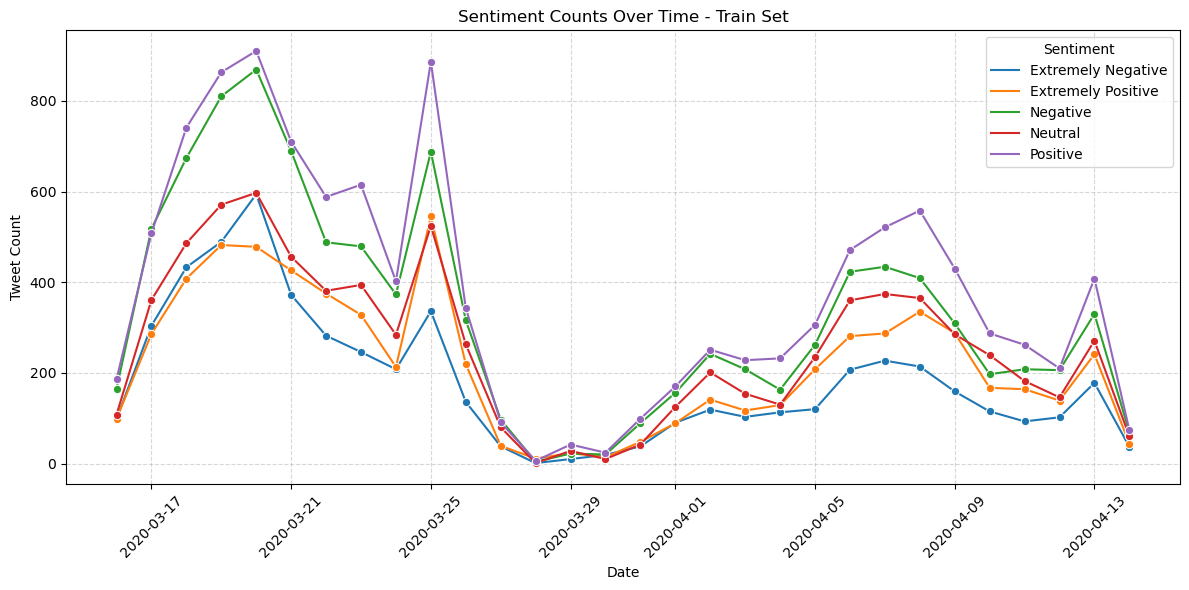

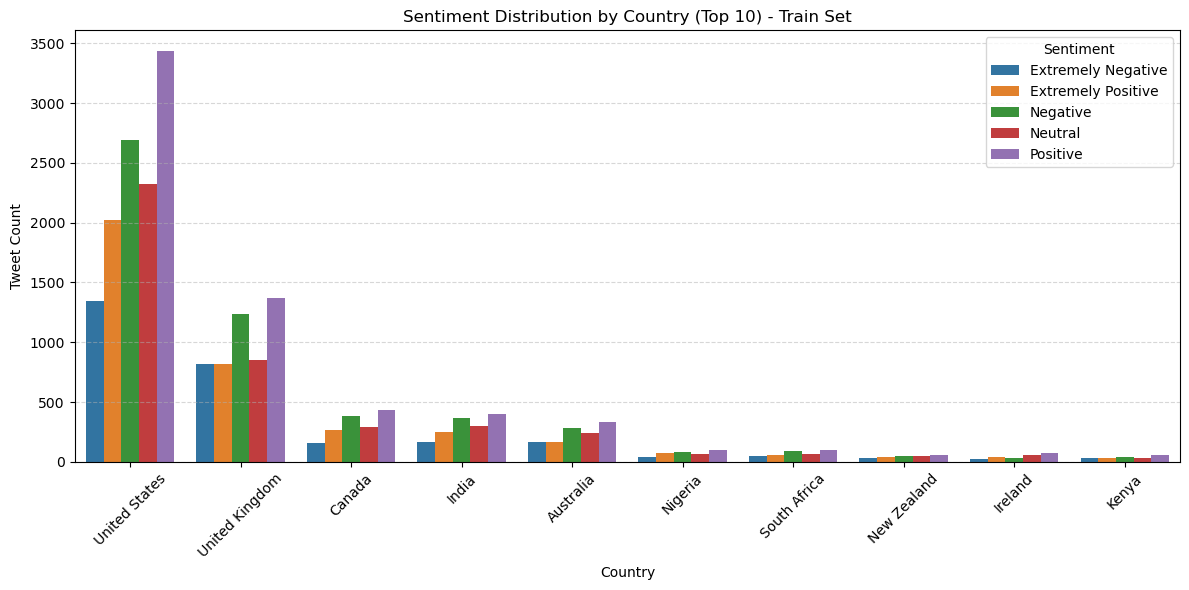

In [62]:
## Plot sentiment counts over time and location
# Convert date column to datetime
df_train['TweetAt'] = pd.to_datetime(df_train['TweetAt'],format='%d-%m-%Y', errors='coerce')

# Drop rows where TweetAt is missing
df_train = df_train.dropna(subset=['TweetAt'])

# Group by date and sentiment
daily_sentiment_train = df_train.groupby(['TweetAt', 'Sentiment']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sentiment_train, x='TweetAt', y='Count', hue='Sentiment', marker='o')
plt.title("Sentiment Counts Over Time - Train Set")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## By location
# Limit to top 10 locations
top_locations_train = df_train['Country'].value_counts().nlargest(10).index
filtered_df_train = df_train[df_train['Country'].isin(top_locations_train)]

# Group by location and sentiment
location_sentiment_train = filtered_df_train.groupby(['Country', 'Sentiment']).size().reset_index(name='Count')

# Determine sorting order based on total counts
order = (
    location_sentiment_train.groupby('Country')['Count']
    .sum()
    .sort_values(ascending=False)
    .index
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=location_sentiment_train, x='Country', y='Count', hue='Sentiment', order=order)
plt.title("Sentiment Distribution by Country (Top 10) - Train Set")
plt.xlabel("Country")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Tweet Length Distribution**

Distribution of tweet lengths (in characters) for both the training and validation sets. This helps identify outliers, understand content variability, and ensure consistency between datasets before modeling.

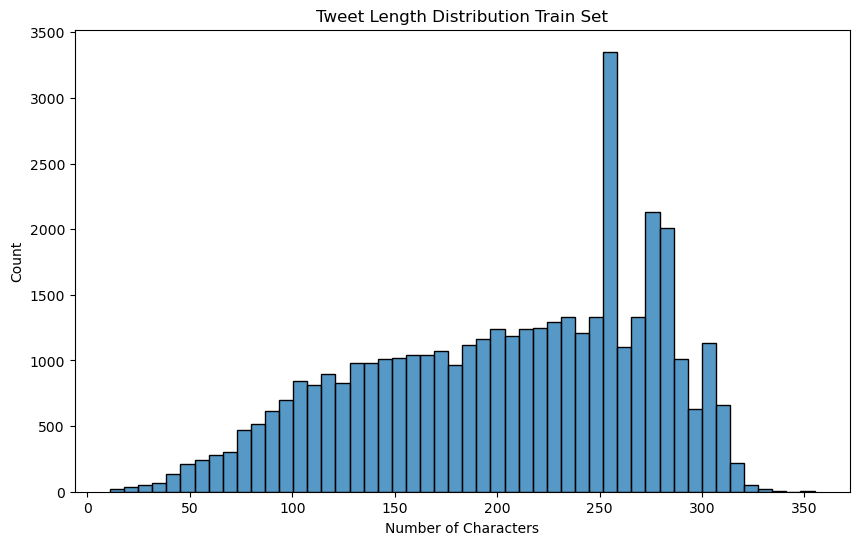

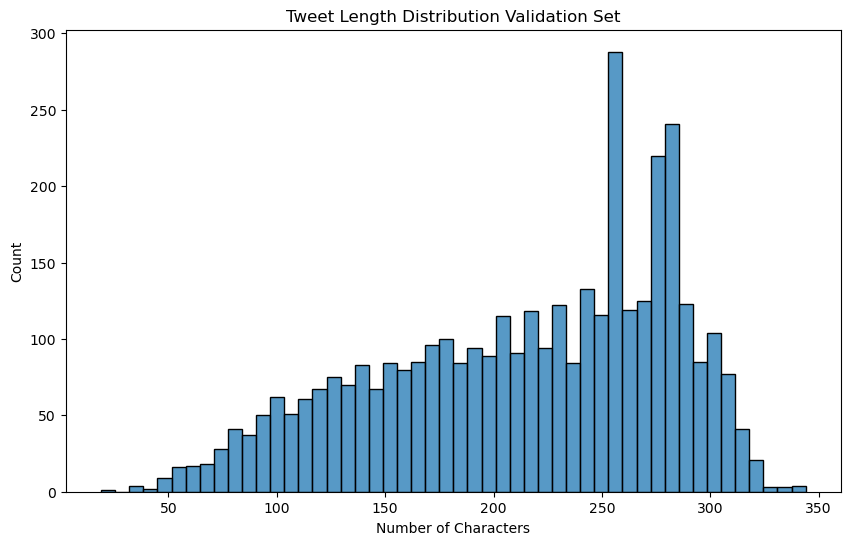

In [63]:
# Display tweet length distribution
df_train['TweetLength'] = df_train['OriginalTweet'].apply(len)
df_val['TweetLength'] = df_val['OriginalTweet'].apply(len)

# Plot distribution
plt.figure(figsize=(10,6))
sns.histplot(df_train['TweetLength'], bins=50)
plt.title("Tweet Length Distribution Train Set")
plt.xlabel("Number of Characters")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df_val['TweetLength'], bins=50)
plt.title("Tweet Length Distribution Validation Set")
plt.xlabel("Number of Characters")
plt.show()

**Word Clouds**

Generating word clouds from the raw tweets to visualize the most frequent words in the dataset. Providing a general overview of the vocabulary used during the COVID-19 period.

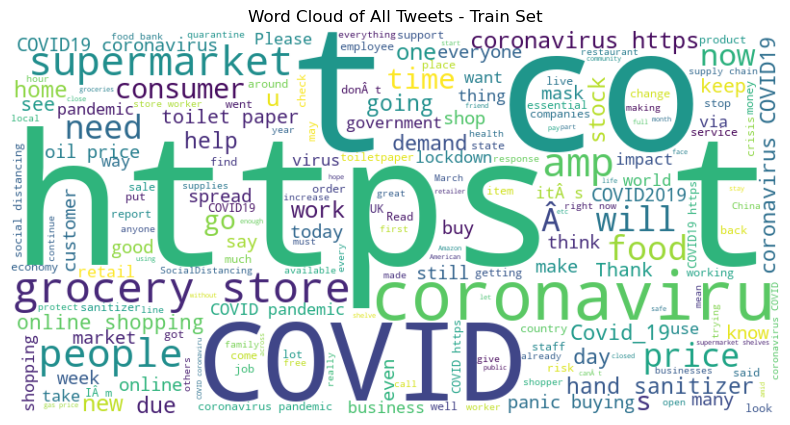

In [64]:
## Display word cloud to visualize more frequent words in tweets
# Create text from all tweets
text_train = " ".join(tweet for tweet in df_train['OriginalTweet'])
# text_val = " ".join(tweet for tweet in df_val['OriginalTweet'])

# Generate NON-FILTERED word cloud
wordcloud_train = WordCloud(width=800, height=400, background_color='white').generate(text_train)
# wordcloud_val = WordCloud(width=800, height=400, background_color='white').generate(text_val)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Tweets - Train Set")
plt.show()

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud_val, interpolation='bilinear')
# plt.axis('off')
# plt.title("Word Cloud of All Tweets - Validation Set")
# plt.show()

To obtain a more meaningful visualization, we create a filtered word cloud where we remove:
stopwords (e.g., "the", "and", "is"),
common noise seen above, like "https", "amp", or "t",
and domain-specific terms like "covid", "coronavirus", etc.

This helps highlight non-trivial themes in the tweets.

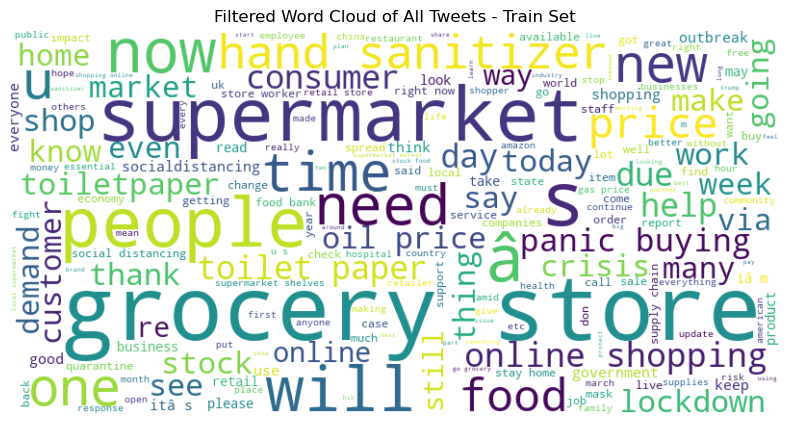

In [65]:
# Generate filtered word cloud - remove unmeaningful words
def clean_text_for_wordcloud(text, exact_banned_words_set, banned_substrings_list, stopwords_set):
   # Normalize case + strip punctuation
    words = re.findall(r'\b\w+\b', text.lower())  
    filtered_words = [
        word for word in words
        if word not in exact_banned_words_set
        and not any(sub in word for sub in banned_substrings_list)
        and word not in stopwords_set
    ]
    return " ".join(filtered_words)

# Define stopwords and filters
all_stopwords = set(STOPWORDS)
exact_banned_words = {'t', 'co', 'https', 'amp'}
banned_substrings = ['covid', 'corona', 'virus', 'pandemic']

# Apply to texts
text_train_clean = clean_text_for_wordcloud(text_train, exact_banned_words, banned_substrings, all_stopwords)
# text_val_clean = clean_text_for_wordcloud(text_val, exact_banned_words, banned_substrings, all_stopwords)

# Generate word clouds
wordcloud_train_clean = WordCloud(width=800, height=400, background_color='white').generate(text_train_clean)
# wordcloud_val_clean = WordCloud(width=800, height=400, background_color='white').generate(text_val_clean)

# Plot filtered word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_train_clean, interpolation='bilinear')
plt.axis('off')
plt.title("Filtered Word Cloud of All Tweets - Train Set")
plt.show()

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud_val_clean, interpolation='bilinear')
# plt.axis('off')
# plt.title("Filtered Word Cloud of All Tweets - Validation Set")
# plt.show()

**Top Words per Sentiment**

Most frequent words per sentiment analysis, after cleaning the tweets—removing stopwords, punctuation, numbers, and common domain terms like "covid". This highlights meaningful differences in language across Positive, Negative, and Neutral tweets, helping understand sentiment-specific word usage.

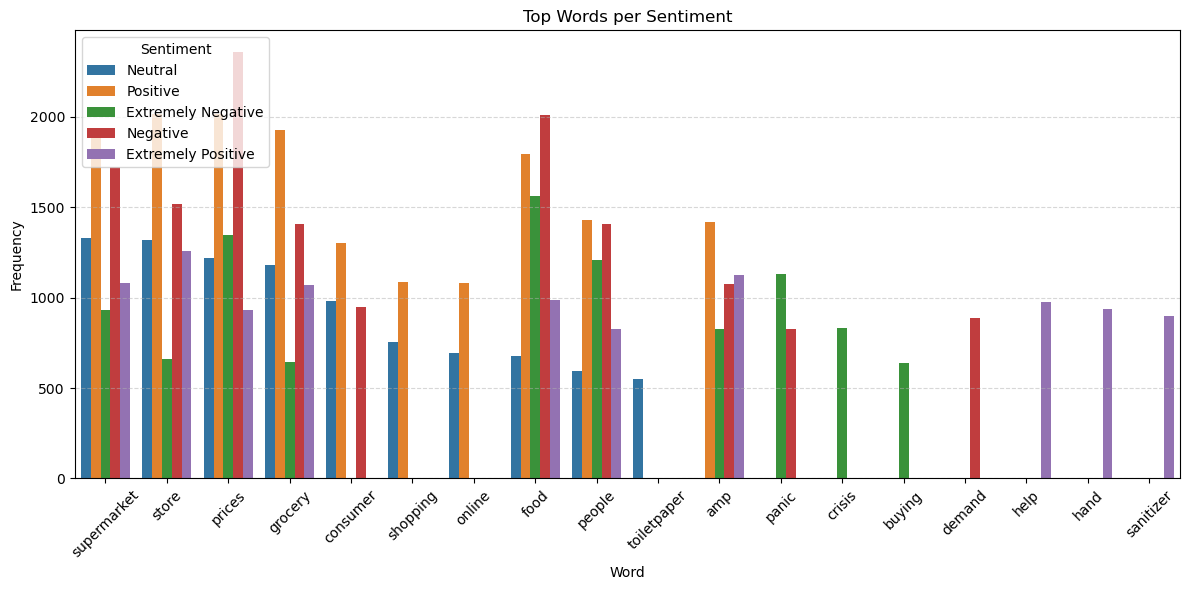

In [66]:
# Set up stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

domain_stopwords = {'covid', 'covid19', 'coronavirus', 'pandemic', 'corona', 'virus'}

# Tokenization + Cleaning Function
def tokenize_and_clean_filtered(text):
    words = str(text).lower().split()
    cleaned_words = []
    
    for word in words:
        word = word.strip(string.punctuation)  # reassign cleaned word
        
        if (
            word not in stop_words
            and word not in domain_stopwords
            and not any(char.isdigit() for char in word)
            and word not in punctuation
            and len(word) > 2
        ):
            cleaned_words.append(word)
    
    return cleaned_words


# Count top N words per sentiment
def get_top_words_by_sentiment(df, text_col='OriginalTweet', label_col='Sentiment', top_n=10):
    sentiment_top_words = {}

    for sentiment in df[label_col].unique():
        subset = df[df[label_col] == sentiment]
        all_words = []
        for tweet in subset[text_col]:
            all_words.extend(tokenize_and_clean_filtered(tweet))
        
        most_common = Counter(all_words).most_common(top_n)
        sentiment_top_words[sentiment] = most_common

    return sentiment_top_words

top_words_train = get_top_words_by_sentiment(df_train)

# Convert for plotting
rows = []
for sentiment, word_counts in top_words_train.items():
    for word, count in word_counts:
        rows.append({"Sentiment": sentiment, "Word": word, "Count": count})

df_top_words = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_words, x='Word', y='Count', hue='Sentiment')
plt.title("Top Words per Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Bigram and Trigram Analysis**

To uncover common patterns and expressions beyond individual words, bigram and trigram analysis was performed. This helps identify meaningful word combinations that frequently appear together in the tweets, such as "online shopping" or "stay home". These multi-word phrases often carry more semantic weight than isolated words and can reveal recurring themes, public concerns, and behavior patterns during the COVID-19 pandemic.

This analysis complements unigram (single-word) frequency by capturing context and phrase-level insights in the data.

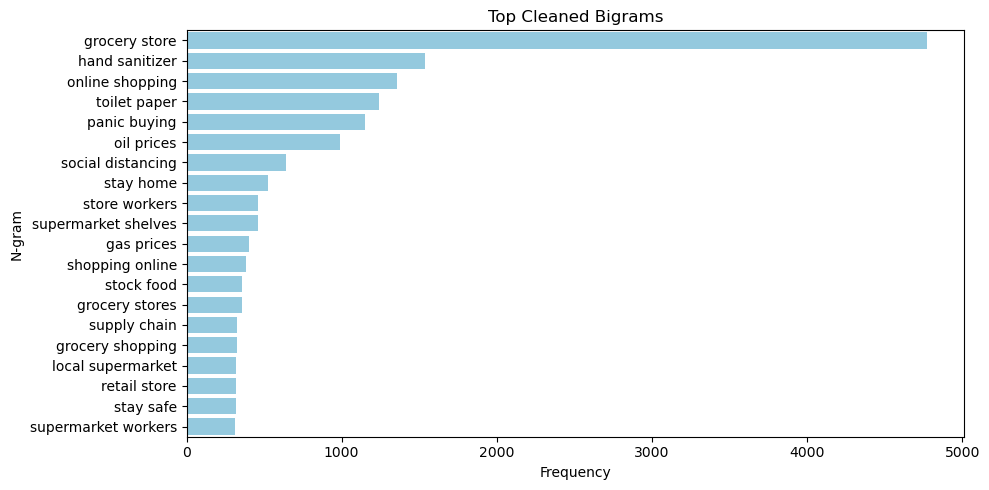

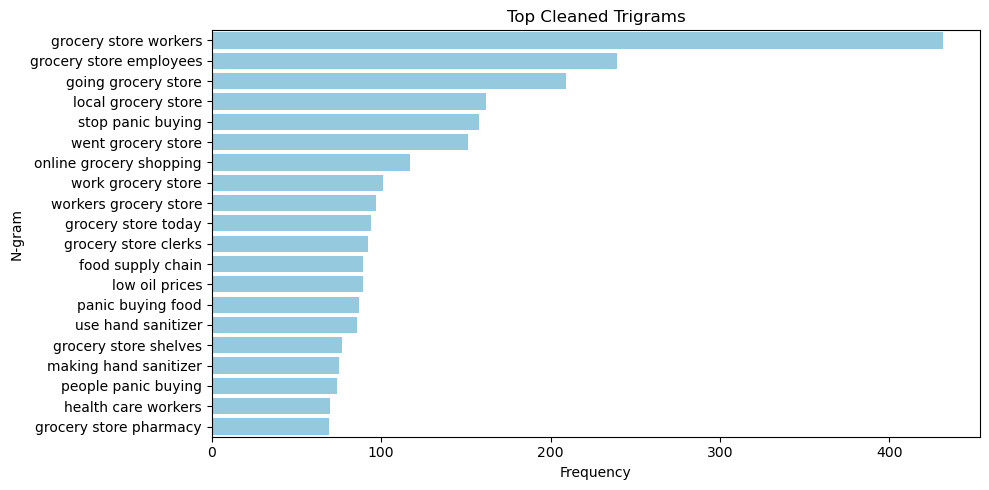

In [67]:
# Apply cleaning to all text entries
df_train['cleaned_tweets'] = df_train['OriginalTweet'].apply(lambda x: ' '.join(tokenize_and_clean_filtered(x)))

# Combine all text into a single corpus
corpus = df_train['cleaned_tweets'].dropna().tolist()

# Function to plot top n-grams
def plot_ngrams(corpus, ngram_range=(2, 2), top_n=20, title='Top N-grams'):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    # Create a DataFrame for visualization
    ngram_df = pd.DataFrame(words_freq, columns=['ngram', 'count'])

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='count', y='ngram', data=ngram_df, color='skyblue')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

# Plot top bigrams + trigrams
plot_ngrams(corpus, ngram_range=(2, 2), title='Top Cleaned Bigrams')
plot_ngrams(corpus, ngram_range=(3, 3), title='Top Cleaned Trigrams')

**Emoji Analysis**

Emojis often convey strong emotional signals and can complement or even replace words in expressing sentiment.<br>
However, due to encoding issues, most emojis were corrupted and appeared as symbols like © and ®. Attempts to fix this using different encodings failed. <br>
Therefore, this analysis couldn't be completed.

In [68]:
# import emoji

# def extract_emojis(text):
#     return [char for char in text if char in emoji.EMOJI_DATA]

# # Apply to data
# df_train['emojis'] = df_train['OriginalTweet'].apply(extract_emojis)

In [69]:
# # Create separate counters
# emoji_counters = {
#     'Extremely Positive': Counter(),
#     'Positive': Counter(),
#     'Neutral': Counter(),
#     'Negative': Counter(),
#     'Extremely Negative': Counter()
# }

# # Count emojis for each sentiment
# for _, row in df_train.iterrows():
#     sentiment = row['Sentiment'] 
#     emojis = row['emojis']
#     emoji_counters[sentiment].update(emojis)

In [70]:
# # Plot top 10 emojis per sentiment
# for sentiment, counter in emoji_counters.items():
#     top_emojis = counter.most_common(10)
#     emojis, counts = zip(*top_emojis)
    
#     plt.figure(figsize=(8, 4))
#     plt.bar(emojis, counts, color='skyblue')
#     plt.title(f"Top Emojis in {sentiment.capitalize()} Tweets")
#     plt.xlabel("Emoji")
#     plt.ylabel("Count")
#     plt.tight_layout()
#     plt.show()

**Hashtag Analysis**

Hashtags provide valuable insight into the main topics users focus on in their tweets. By analyzing hashtags per sentiment, we aim to understand which topics are associated with different emotional tones during the COVID-19 pandemic.

The most common hashtags across different sentiment categories show hashtags like `#coronavirus`and `#covid19` variations were the most frequently used as expected, and appeared in tweets of all sentiment types. 

Some hashtags such as `#toiletpaper` and `#panicbuying` showed stronger associations with specific sentiments, indicating public emotional responses to particular aspects of the crisis.

<Figure size 1000x600 with 0 Axes>

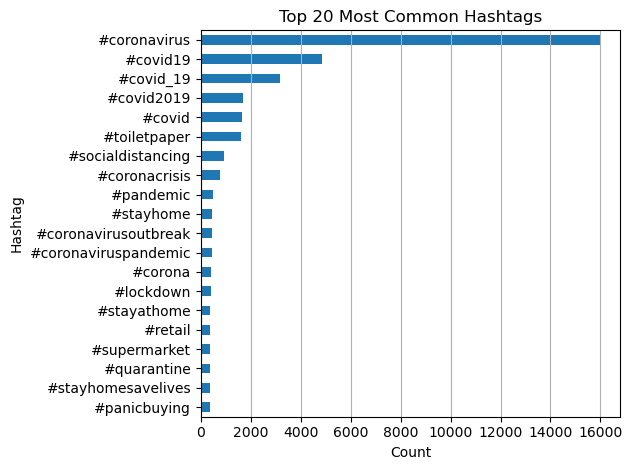

In [71]:
# Extract hashtags from each tweet
def extract_hashtags(text):
    return re.findall(r"#\w+", str(text).lower())

# Apply on tweets
df_train['hashtags'] = df_train['OriginalTweet'].apply(extract_hashtags)

# Flatten all hashtags into a single list
all_hashtags = [hashtag for hashtags in df_train['hashtags'] for hashtag in hashtags]

# Count most common hashtags
hashtag_counts = Counter(all_hashtags).most_common(20)

# Convert to DataFrame for plotting
hashtag_df = pd.DataFrame(hashtag_counts, columns=["hashtag", "count"])

# Plot
plt.figure(figsize=(10,6))
hashtag_df.sort_values("count", ascending=True).plot.barh(x="hashtag", y="count", legend=False)
plt.title("Top 20 Most Common Hashtags")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

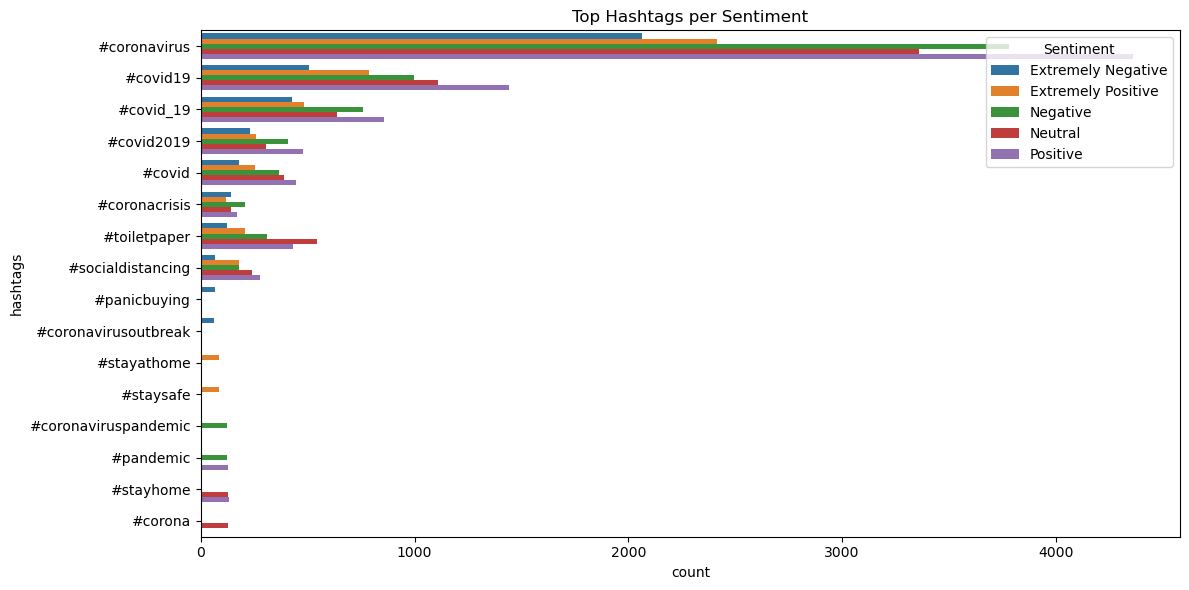

In [72]:
# Explode hashtags column to have one hashtag per row
exploded = df_train.explode('hashtags')

# Group by sentiment and hashtag
sentiment_hashtags = exploded.groupby(['Sentiment', 'hashtags']).size().reset_index(name='count')

# Filter to top 10 for each sentiment
top_hashtags_per_sentiment = sentiment_hashtags.groupby('Sentiment').apply(
    lambda x: x.sort_values('count', ascending=False).head(10)
).reset_index(drop=True)

# Plot
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(data=top_hashtags_per_sentiment, x='count', y='hashtags', hue='Sentiment')
plt.title('Top Hashtags per Sentiment')
plt.tight_layout()
plt.show()

### Pre-processing the Data

The tweets were cleaned by lowercasing (to reduce redundancy), removing stopwords, punctuation, numbers, short words, and applying lemmatization to reduce words to their base form (e.g. running → run). <br>This helps reduce noise and improve model performance.


In [87]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)              # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)                     # Remove punctuation & numbers
    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
        and word not in domain_stopwords
        and len(word) > 2
    ]
    return " ".join(tokens)

df_train["clean_text"] = df_train["OriginalTweet"].apply(preprocess_text)
df_val["clean_text"] = df_val["OriginalTweet"].apply(preprocess_text)

## Fine-Tuning Pretrained Language Models

Apply NLP techniques using transfer learning on our tweets dataset. Specifically, fine-tuning two pretrained transformer-based models from the Hugging Face library — BERT and RoBERTa — on our sentiment classification task. These models will be trained using both standard PyTorch and the Hugging Face API. Model performance will be monitored and tuned using hyperparameter optimization (Optuna) and experiment tracking (Weights & Biases).

**Load Pretrained Models**

Initialize tokenizers and models for BERT and RoBERTa, both widely used transformer architectures for text classification. The classification head is configured based on the number of sentiment labels.

In [88]:
# Choose pretrained models
bert_model_name = "bert-base-uncased"      
roberta_model_name = "roberta-base"

n_labels = len(sentiment_labels)

# Load BERT tokenizer and model
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=n_labels)

# Load RoBERTa tokenizer and model
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name, num_labels=n_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Encode Sentiment Labels**

Map each unique sentiment label to a numeric ID for model compatibility, and apply this mapping to both training and validation datasets.

In [89]:
# Mapping sentiments to unique numeric IDs
label2id = {label: idx for idx, label in enumerate(df_train["Sentiment"].unique())}
id2label = {idx: label for label, idx in label2id.items()}

df_train["label"] = df_train["Sentiment"].map(label2id)
df_val["label"] = df_val["Sentiment"].map(label2id)

**Tokenization**

Define tokenization functions for BERT and RoBERTa to preprocess text with truncation and fixed padding.

Transform training and validation DataFrames into Dataset objects compatible with Hugging Face workflows.

Apply tokenization to training and validation datasets using each model's tokenizer.

In [90]:
# Tokenize function
def tokenize_function_bert(examples):
    return bert_tokenizer(examples["clean_text"], truncation=True, padding='max_length', max_length=128)

def tokenize_function_roberta(examples):
    return roberta_tokenizer(examples["clean_text"], truncation=True, padding='max_length', max_length=128)

In [91]:
# Convert DataFrame to Hugging Face Dataset
hf_dataset_train = Dataset.from_pandas(df_train[["clean_text", "label"]])
hf_dataset_val = Dataset.from_pandas(df_val[["clean_text", "label"]])

In [92]:
# Tokenize for BERT
tokenized_bert_train = hf_dataset_train.map(tokenize_function_bert, batched=True)
tokenized_bert_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenized_bert_val = hf_dataset_val.map(tokenize_function_bert, batched=True)
tokenized_bert_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Tokenize for RoBERTa
tokenized_roberta_train = hf_dataset_train.map(tokenize_function_roberta, batched=True)
tokenized_roberta_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenized_roberta_val = hf_dataset_val.map(tokenize_function_roberta, batched=True)
tokenized_roberta_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/41157 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

Map:   0%|          | 0/41157 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

In [93]:
# Define evaluation metric, Set up an evaluation function using accuracy as the metric to assess model performance during training.

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

**Define Training Arguments**

Configure hyperparameters and training settings for both BERT and RoBERTa models, including batch size, number of epochs, learning rate, and evaluation strategy.

In [94]:
bert_training_args = TrainingArguments(
    output_dir="./results/bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs/bert",
    report_to="none"  # prevents wandb or other integrations
)

In [95]:
roberta_training_args = TrainingArguments(
    output_dir="./results/roberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs/roberta",
    report_to="none"
)

**Use Small Subsets for Quick Evaluation**

Select shuffled samples from each training and validation dataset for both BERT and RoBERTa. This allows faster experimentation during model development.

In [ ]:
small_train_dataset_bert = tokenized_bert_train.shuffle(seed=42).select(range(1000))
small_val_dataset_bert = tokenized_bert_val.shuffle(seed=42).select(range(1000))

small_train_dataset_roberta = tokenized_roberta_train.shuffle(seed=42).select(range(1000))
small_val_dataset_roberta = tokenized_roberta_val.shuffle(seed=42).select(range(1000))

**Initialize Trainers**

Configure Trainer objects for both BERT and RoBERTa using the small training and validation sets, tokenizers, training arguments, and evaluation metric.

In [96]:
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=small_train_dataset_bert,
    eval_dataset=small_val_dataset_bert,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\hilla\AppData\Local\Temp\ipykernel_13904\2693036705.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert_trainer = Trainer(


In [97]:
roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=small_train_dataset_roberta,
    eval_dataset=small_val_dataset_roberta,
    tokenizer=roberta_tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\hilla\AppData\Local\Temp\ipykernel_13904\4014123999.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(


**Model Training**

Train both BERT and RoBERTa models on the small datasets using the Trainer interface.

In [98]:
bert_trainer.train()
roberta_trainer.train()